In [32]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [33]:
# Check data
mat = sp.io.loadmat("dataset1.mat")

mat.keys()
# '__header__', '__version__', '__globals__',
# 'r', 'x_true', 't', 'v', 'l', 'r_var', 'v_var'

r = mat["r"]
x_true = mat["x_true"]
t = mat["t"]
v = mat["v"]
l = mat["l"]
r_var = mat["r_var"]
v_var = mat["v_var"]
# print(r.shape, x_true.shape, t.shape, v.shape, l.shape, r_var.shape, v_var.shape)

# (1,) -> (12709,)
l = np.broadcast_to(l, r.shape)
r_var = np.broadcast_to(r_var, r.shape)
v_var = np.broadcast_to(v_var, r.shape)

col_name = ["r", "x_true", "t", "v", "l", "r_var", "v_var"]
df = pd.DataFrame(np.hstack([r, x_true, t, v, l, r_var, v_var]), columns=col_name)
df.head(20)

,r,x_true,t,v,l,r_var,v_var
0,3.454506,0.984457,0.0,0.0,4.428479,0.000367,0.002261
1,3.456506,0.984434,0.1,0.0,4.428479,0.000367,0.002261
2,3.452506,0.984518,0.2,0.0,4.428479,0.000367,0.002261
3,3.454506,0.984452,0.3,0.0,4.428479,0.000367,0.002261
4,3.451506,0.984406,0.4,0.0,4.428479,0.000367,0.002261
5,3.456506,0.984454,0.5,0.0,4.428479,0.000367,0.002261
6,3.452506,0.984420,0.6,0.0,4.428479,0.000367,0.002261
7,3.452506,0.984401,0.7,0.0,4.428479,0.000367,0.002261
8,3.452506,0.984443,0.8,0.0,4.428479,0.000367,0.002261
9,3.450506,0.984389,0.9,0.0,4.428479,0.000367,0.002261


In [34]:
# load data
mat = sp.io.loadmat("dataset1.mat")
r = mat["r"].reshape(-1)
x_true = mat["x_true"].reshape(-1)
t = mat["t"].reshape(-1)
v = mat["v"].reshape(-1)
l = mat["l"].reshape(-1)
r_var = mat["r_var"].reshape(-1)
v_var = mat["v_var"].reshape(-1)


K = x_true.shape[0]  # 12709
T = 0.1

delta = 1
k = (K - 1) // delta  # number of sub-samples

# make z
## make u
# u = np.zeros((k, 1))
# for i in range(0, k):
#     u[i] = T * v[i * delta : (i + 1) * delta].sum()

u = np.array([T * v[i * delta : (i + 1) * delta].sum() for i in range(0, k)]).reshape(
    -1, 1
)

## make y
# y = np.zeros((k, 1))
# for i in range(0, k):
#     y[i] = l[0] - r[(i + 1) * delta]

y = np.array([l[0] - r[(i + 1) * delta] for i in range(0, k)]).reshape(-1, 1)

## make z
z = np.vstack([u, y])

# make H
## make A_inv
A_inv = np.eye(k)
for row in range(A_inv.shape[0]):
    A_inv[row, row - 1] = -1

## make C
C = np.eye(k)

## make H
H = np.vstack([A_inv, C])

# make W
## make Q, R
Q = np.eye(k) * v_var[0]
R = np.eye(k) * r_var[0]

## make W
W = np.block([[Q, np.zeros((k, k))], [np.zeros((k, k)), R]])
W_inv = np.linalg.inv(W)

# solution
## by formula

### sparse way
z_sparse = sp.sparse.csr_matrix(z)
H_sparse = sp.sparse.csr_matrix(H)
W_inv_sparse = sp.sparse.csr_matrix(W_inv)
P_check_sparse = sp.sparse.linalg.inv(H_sparse.T * W_inv_sparse * H_sparse)

x = P_check_sparse * H_sparse.T * W_inv_sparse * z

### dense way
# x = np.linalg.inv(H.T @ W_inv @ H) @ H.T @ W_inv @ z

## by numpy least square
# W_sqrt_inv = np.linalg.cholesky(W_inv).T
# z_weighted = W_sqrt_inv @ z
# H_weighted = W_sqrt_inv @ H

# x, residuals, rank, s = np.linalg.lstsq(H_weighted, z_weighted, rcond=None)

x = x.reshape(-1)

x_true_sub = x_true[delta:K:delta]

error = x_true_sub - x

x_3_sigma_positive = x_true_sub + 3 * np.abs(error)
x_3_sigma_negative = x_true_sub - 3 * np.abs(error)

# error

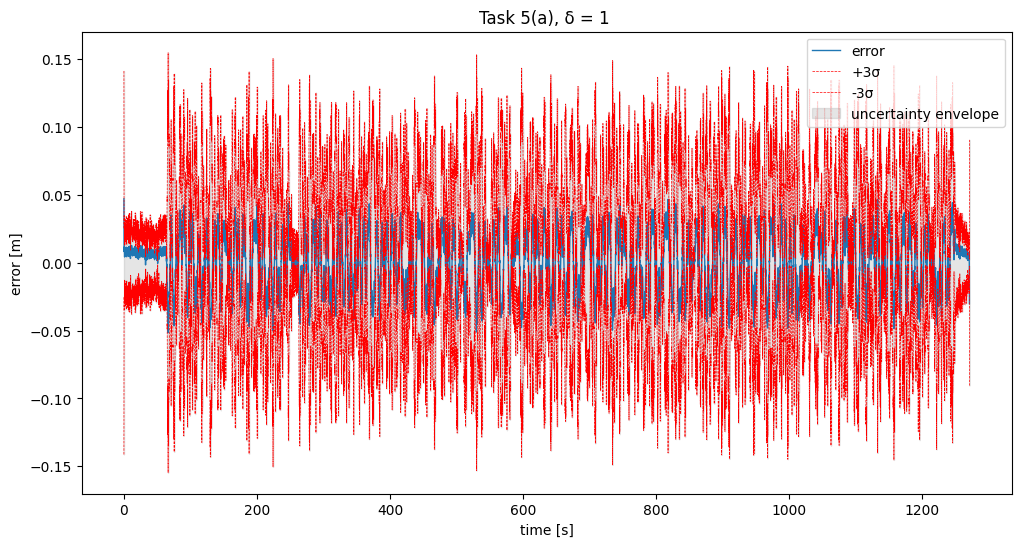

In [35]:
t = [(i + 1) * delta * T for i in range(0, k)]

# coefs = np.polyfit(delta_t, x_true_sub, 3)
# p = np.poly1d(coefs)

# x_smooth = np.linspace(0, K)
# y_smooth = p(x_smooth)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title("Task 5(a), δ = {} ".format(delta))
ax.set_xlabel("time [s]")
ax.set_ylabel("error [m]")
ax.plot(t, error, linewidth=1, label="error")
ax.plot(t, 3 * np.abs(error), color="red", linewidth=0.5, linestyle="--", label="+3σ")
ax.plot(t, -3 * np.abs(error), color="red", linewidth=0.5, linestyle="--", label="-3σ")
# ax.plot(x_smooth, y_smooth, label="x_true_smooth")
ax.fill_between(
    t,
    -3 * np.abs(error),
    3 * np.abs(error),
    color="gray",
    alpha=0.2,
    label="uncertainty envelope",
)
ax.legend()

(array([ 0.15951545,  0.23927318,  0.35890977,  0.91721385,  1.43563907,
         2.35285291,  5.22413105,  5.94195058,  7.57698396,  8.13528804,
         8.33468235,  8.21504577, 10.04947346, 11.4053548 , 10.52801982,
        10.24886778, 10.56789868, 11.7243857 , 12.04341661, 12.20293206,
        13.19990363, 13.43917681, 16.66936471, 18.14488264, 18.14488264,
        17.70621515, 16.70924357, 15.79202972, 21.65422258, 28.23423496,
        26.7985959 , 20.13882579, 14.67542156, 14.47602725, 11.60474912,
        12.40232637, 13.08026704, 13.91772317, 14.35639066, 10.44826209,
        12.00353775,  8.85310757,  5.86219285,  4.74558469,  3.03079358,
         1.51539679,  0.79757726,  0.27915204,  0.3190309 ,  0.11963659]),
 array([-0.05157395, -0.04960071, -0.04762747, -0.04565423, -0.04368099,
        -0.04170775, -0.03973451, -0.03776127, -0.03578803, -0.03381479,
        -0.03184155, -0.02986831, -0.02789506, -0.02592182, -0.02394858,
        -0.02197534, -0.0200021 , -0.01802886, -0

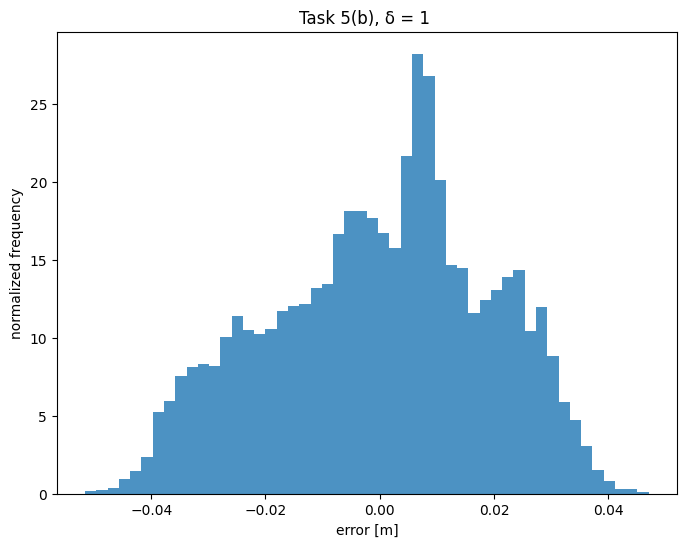

In [36]:
# histogram
n_bins = 50
# error_space = error.max() - error.min()
# interval = error_space / n_bins

# hist = np.zeros(n_bins)
# for val in error:
#     idx = int(abs(val - error.min()) / (interval + 1e-10))
#     hist[idx] += 1
# hist_norm = hist / hist.sum()

# histogram
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title("Task 5(b), δ = {} ".format(delta))
ax.set_xlabel("error [m]")
ax.set_ylabel("normalized frequency")
ax.hist(error, bins=n_bins, density=True, alpha=0.8, label="error")